Lab11 - mnist cnn keras best keras eager

NN implementation flow in tensorflow

 1. Set hyper parameters - learning rate, training epochs, batch size, etc.
 2. (New!) Data Augmentation - rotate & shift
 3. Make a data pipelining - use tf.data (batch size만큼 데이터를 가져와서 network에 공급)
 4. Build a neural network model - use tf.keras sequential APIs
 5. Define a loss function - cross entropy
 6. Calculate a gradient - use tf.GradientTape
 7. Select an Optimizer - Adam Optimizer
 8. Define a metric for model's performance - accuracy
 9. (optional) Make a checkpoint for saving
 10. Train and Validate a neural network model

How to get the Best Performance

 1. Data Augmentation
 2. Batch Normalization
 3. Model Ensemble
 4. Learning Rate Decay

# Libraries

In [1]:
from IPython.display import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage # for data augmentation

구현하고자 하는 Network의 구조


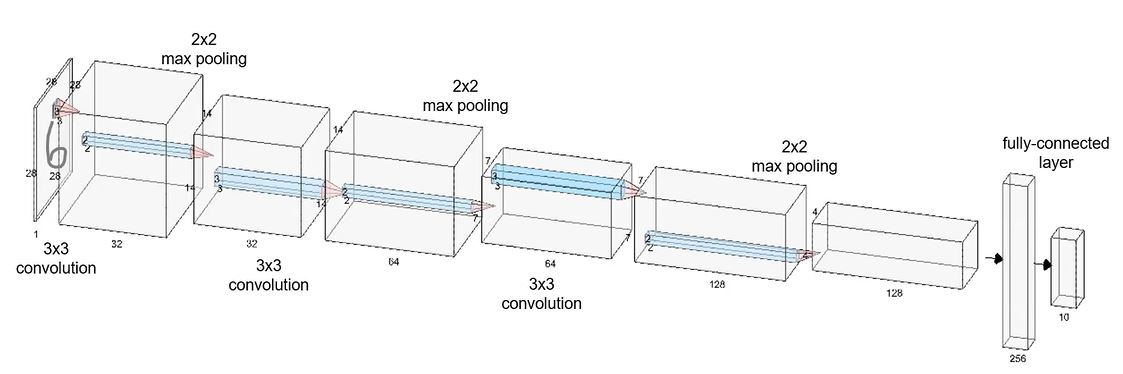

In [2]:
print('구현하고자 하는 Network의 구조')
Image('C:/Users/rsh15/Desktop/cnn sample.jpg')

# Data Augmentation

In [3]:
def data_augmentation(images, labels):
    aug_images = []
    aug_labels = []    
    
    for x, y in zip(images, labels):        
        aug_images.append(x)
        aug_labels.append(y)
        
        bg_value = np.median(x)
        for _ in range(4):
            angle = np.random.randint(-15, 15, 1)
            rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value)
            
            shift = np.random.randint(-2, 2, 2)
            shift_img = ndimage.shift(rot_img, shift, cval=bg_value)            
            
            aug_images.append(shift_img)
            aug_labels.append(y)
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

# Set hyper-parameters & check points

In [4]:
# hyper parameter
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [5]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_best'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

# Data Pipeline

In [9]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images, train_labels = data_augmentation(train_images, train_labels)
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=500000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

 # Model Subclassing

 * Convolution Layer - Batch Normalization - ReLU의 순서

In [10]:
class ConvBNRelu(tf.keras.Model):
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME'):
        super(ConvBNRelu, self).__init__()
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                                        padding=padding, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer        
    
class DenseBNRelu(tf.keras.Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = keras.layers.Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [11]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=[3, 3], padding='SAME')        
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], padding='SAME')
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3], padding='SAME')
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = DenseBNRelu(units=256)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10, kernel_initializer='glorot_normal')
        
    def call(self, inputs, training=False):
        net = self.conv1(inputs)        
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [12]:
models = []
num_models = 5
for m in range(num_models):
    models.append(MNISTModel())

# Define Loss function, Gradient

In [13]:
def loss_fn(model, images, labels):
    logits = model(images, training=True) # training=True면 dropout이 적용됨. 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return loss

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

# Optimizer, Metric, Checkpoint

In [16]:
global_step = tf.compat.v1.train.get_or_create_global_step()
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,global_step,
                                      train_images.shape[0]/batch_size*num_models*5,
                                      0.5)
optimizer = tf.optimizers.Adam(learning_rate=lr_decay)

def evaluate(models, images, labels):
    predictions = tf.zeros_like(labels) # 모델 3개에서 나오는 Output들. 빈 것을 만들어놓고, 모델별 Output을 구해서 넣는다.
    for model in models:
        logits = model(images, training=False)
        predictions += logits
    correct_prediction = tf.equal(tf.argmax(predictions,1),tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    return accuracy

checkpoints = []
for m in range(num_models):
    checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

# Train and Validate Neural Network Model

In [17]:
for epoch in range(training_epochs): 
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        for model in models:
            grads = grad(model, images, labels)
            optimizer.apply_gradients(zip(grads, model.variables))
            loss = loss_fn(model, images, labels)
            avg_loss += loss / num_models # 모델의 개수로 나눠준다.
        acc = evaluate(models, images, labels)
        avg_train_acc += acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:
        acc = evaluate(models, images, labels)
        avg_test_acc += acc
        test_step += 1
    avg_test_acc = avg_test_acc / test_step
    
    print('Epoch:','{}'.format(epoch+1),'loss = ','{:.8f}'.format(avg_loss),
          'train_accuracy = ','{:.4f}'.format(avg_train_acc),
          'test_accuracy  = ','{:.4f}'.format(avg_test_acc))
    
    for idx, checkpoint in enumerate(checkpoints):
        checkpoint.save(file_prefix=checkpoint_prefix+'-{}'.format(idx))

KeyboardInterrupt: 